**Loading Dependencies:**

In [1]:
# for system settings
import os
os.chdir("C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/")
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import time
# for excessing or creating tabular data
import pandas as pd
# import pandas.util.testing as tm
# for matrix manipulation
import numpy as np
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# for splitting the data
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv("train.csv")
print("train.csv:")
print("Number of Training images: {}\n".format(train_data.shape[0]))
print(train_data.head(2),"\n")
print("-"*100)
test_data = pd.read_csv("test.csv")
print("test.csv: ")
print("Number of Testing images: {}\n".format(test_data.shape[0]))
print(test_data.head(2))
print("\n","-"*100)
print("sample_submission.csv:")
sample_submission = pd.read_csv("sample_submission.csv")
print("The format of submitting the final predictions on testing images: ")
print(sample_submission.head(5))

train.csv:
Number of Training images: 3662

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4 

----------------------------------------------------------------------------------------------------
test.csv: 
Number of Testing images: 1928

        id_code
0  0005cfc8afb6
1  003f0afdcd15

 ----------------------------------------------------------------------------------------------------
sample_submission.csv:
The format of submitting the final predictions on testing images: 
        id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0


The competition has given 5 files:

1.    train.csv  -> which contains two columns id_code (path of the training images) and diagnosis (target class)
2.    test.csv  -> which contains one column id_code (path of the testing images) which we need to predict the class labels.
3.    train_images  -> Folder which contains the training images.
4.    test_images  -> Folder which contains the testing images.
5.    sample_submission.csv -> which contains the template of final submission file to the competition.
*    aptos2019-blindness-detection.zip  -> zip Folder using which we can extract all the above four files.

In [3]:
# Intialization of variables which are useful for the later tasks.
img_width = 224
img_height = 224
no_channels = 3
split_size = 0.1
class_labels = {0: 'No DR[0]',1: 'Mild[1]', 2: 'Moderate[2]', 3: 'Severe[3]', 4: 'Proliferative DR[4]'}

### **Exploratory Data Analysis:**

Number of Images in train dataset:  3662
Number of Images in test dataset:  1928


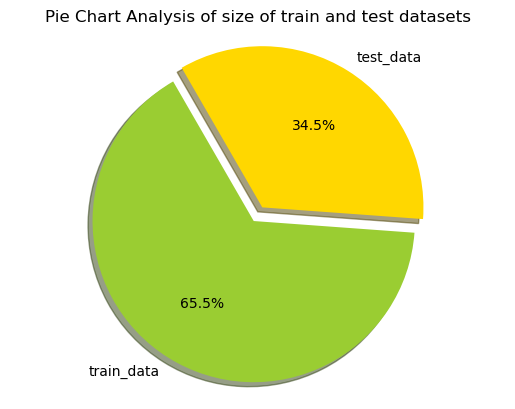

In [4]:
data = [len(train_data), len(test_data)]
print("Number of Images in train dataset: ", data[0])
print("Number of Images in test dataset: ", data[1])
labels = ['train_data','test_data']
plt.pie(data,explode = [0,0.1], labels= labels, shadow = True, colors = ['yellowgreen','gold'],autopct='%1.1f%%', startangle = 120)
plt.title('Pie Chart Analysis of size of train and test datasets')
plt.axis('equal')
plt.show()

*    Both the training and test folders are not too large, Which may not be sufficient for model training. Since the model training is with fewer images, it gets overfitted too easily. So we need to come up with different data augmentation techniques and make use of pretrained models (Transfer Learning) in order to improve the model training.
*    The train data set is three times larger than the test data set.


In [5]:
class_labels_ = list(set(train_data['diagnosis'])) 
print("Number of target classes: {}".format(class_labels_))

Number of target classes: [0, 1, 2, 3, 4]


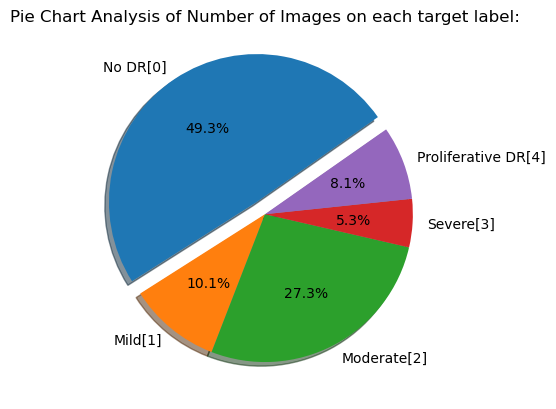

In [6]:
class_sizes = []
for i in range(0,5):
    class_sizes.append(list(train_data['diagnosis']).count(i))
labels = class_labels.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','darkgreen']
plt.pie(class_sizes,explode = [0.1,0,0,0,0], labels= labels, shadow = True,autopct='%1.1f%%', startangle = 35)
plt.title('Pie Chart Analysis of Number of Images on each target label:')
plt.show()

*    We can see that the data is heavily imbalanced. Their are ten times more images with No DR condition than the images with Severe condion.
*    Adding class_weights may solve our problem.

In [7]:
def image_analysis(dataframe, path):
    width_range = []
    height_range = []
    for i in range(dataframe.shape[0]):
        img = cv2.imread(path+dataframe.iloc[i]['id_code']+'.png')
        height, width, _ = img.shape
        width_range.append(width)
        height_range.append(height)
    return width_range, height_range
width_range, height_range = image_analysis(train_data, 'train_images/')

In [8]:
avg_width = sum(width_range)/len(width_range)
avg_height = sum(height_range)/len(height_range)
max_width = max(width_range)
max_height = max(height_range)
min_width = min(width_range)
min_height = min(height_range)
print("Average width of images in training set: {}".format(int(avg_width)))
print("Average height of images in training set: {}".format(int(avg_height)))
print("-"*100)
print("Maximum width of images in training set: {}".format(max_width))
print("Maximum height of images in training set: {}".format(max_height))
print("-"*100)
print("Minimum width of images in training set: {}".format(min_width))
print("Minimum height of images in training set: {}".format(min_height))

Average width of images in training set: 2015
Average height of images in training set: 1526
----------------------------------------------------------------------------------------------------
Maximum width of images in training set: 4288
Maximum height of images in training set: 2848
----------------------------------------------------------------------------------------------------
Minimum width of images in training set: 474
Minimum height of images in training set: 358


In [9]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(width_range, kde = False, label = 'train_width')
sns.distplot(height_range, kde = False, label = 'train_height')
plt.legend()
plt.title("Histogram of Height and Width in Training Images")
plt.subplot(1,2,2)
sns.kdeplot(width_range, label = 'train_width')
sns.kdeplot(height_range, label = 'train_height')
plt.legend()
plt.title('KDE plot of Height and Width in Training Images')
plt.show()

In [10]:
width_range_test, height_range_test = image_analysis(test_data, 'test_images/')
avg_width = sum(width_range_test)/len(width_range_test)
avg_height = sum(height_range_test)/len(height_range_test)
max_width = max(width_range_test)
max_height = max(height_range_test)
min_width = min(width_range_test)
min_height = min(height_range_test)
print("Average width of images in training set: {}".format(int(avg_width)))
print("Average height of images in training set: {}".format(int(avg_height)))
print('-'*100)
print("Maximum width of images in test set: {}".format(max_width))
print("Maximum height of images in test set: {}".format(max_height))
print('-'*100)
print("Minimum width of images in test set: {}".format(min_width))
print("Minimum height of images in test set: {}".format(min_height))

Average width of images in training set: 1043
Average height of images in training set: 783
----------------------------------------------------------------------------------------------------
Maximum width of images in test set: 2896
Maximum height of images in test set: 1958
----------------------------------------------------------------------------------------------------
Minimum width of images in test set: 640
Minimum height of images in test set: 480


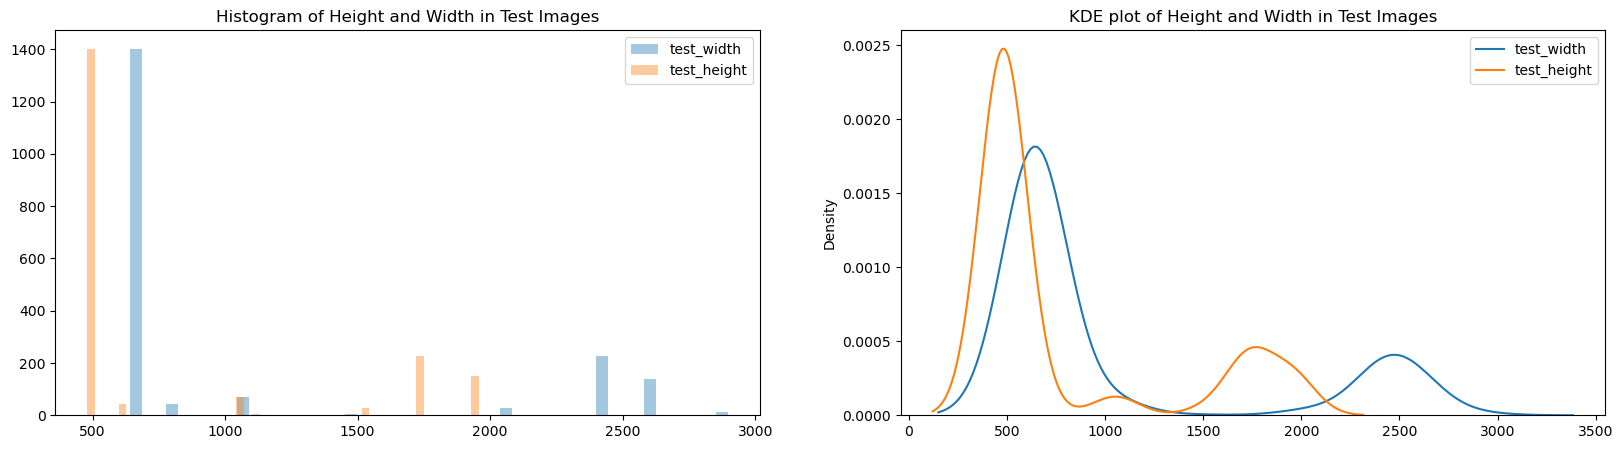

In [11]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(width_range_test, kde = False, label = 'test_width')
sns.distplot(height_range_test, kde = False, label = 'test_height')
plt.legend()
plt.title("Histogram of Height and Width in Test Images")
plt.subplot(1,2,2)
sns.kdeplot(width_range_test, label = 'test_width')
sns.kdeplot(height_range_test, label = 'test_height')
plt.legend()
plt.title('KDE plot of Height and Width in Test Images')
plt.show()

*   Their is no standard shape for images in both train and test datasets.
*   We can see that their are different distribution in (train_width,test_width) and (train_height, test_height).
*   We need to bring all the images into standard resolution.

### **Splitting the Dataset:**

In [12]:
def splitting_data(train_data, size, is_split = True):
    """
       This function splits the given data into train and validation sets basing on size for validation.
       Args : df - (dataframe) through which splitting is performed 
            size - (Integer) test_size -> percentage of data for validation set 
            is_split = (boolean) returns train and validation if it is True , otherwise it simply returns the train data
       Outputs : (Series Object) train and validation sets of data 

    """
    try:
        if is_split:
            data = train_data['id_code']
            labels = train_data['diagnosis']
            train_x, validation_x, train_labels, validation_labels = train_test_split(data, labels, stratify=labels, shuffle=True, test_size=size)
            print("Training data: {} {}".format(train_x.shape, train_labels.shape))
            print("Validation data: {} {}".format(validation_x.shape,validation_labels.shape))
            return train_x, train_labels, validation_x, validation_labels
        else:
            return train_data['id_code'], train_data['diagnosis'], [], []
    except:
        print("Error: Invalid file format, Function argument requires .csv file!!!")

In [13]:
train_x, train_labels, validation_x, validation_labels = splitting_data(train_data, split_size)   # function calling

Training data: (3295,) (3295,)
Validation data: (367,) (367,)


In [46]:
train_x

1479    67844c46bc61
3236    e135d7ba9a0e
188     0dc031c94225
1931    87b671c6d4c5
2900    c9d42d7534e0
            ...     
2151    97a5ad7548b7
3499    f3b6b7ca1eb1
3378    ea68b58a6e8f
285     15bed5adde74
1629    7335a2d43ada
Name: id_code, Length: 3295, dtype: object

**Saving files into folders for future use:**

In [16]:
# train = pd.DataFrame(train_x, columns = ['id_code'])
# train['diagnosis'] = train_labels
# train.to_csv("/content/drive/My Drive/training.csv", index = False)
# validation = pd.DataFrame(validation_x, columns = ['id_code'])
# validation['diagnosis'] = validation_labels
# validation.to_csv('/content/drive/My Drive/validation.csv', index = False)

In [17]:
# test = pd.read_csv('/content/test.csv')
# test.to_csv('/content/drive/My Drive/test.csv', index = False)

In [18]:
# train = pd.read_csv("/content/drive/My Drive/training.csv")
# validation = pd.read_csv("/content/drive/My Drive/validation.csv")
# train_x = train['id_code']
# train_labels = train['diagnosis']
# validation_x = validation['id_code']
# validation_labels = validation['diagnosis']

**Target Labels Analysis on Train and validation sets:**

In [19]:
def class_analysis(labels, d_set):
    """
    This function plots the histogram of class labels for given set of labels.
    Args : labels - (Series object) which contains the class_labels of train or validation sets.
           d_set - (String) which helps to known whether it is a train or validation set.
    Output : None - this function doesn't return anything
    """
    if d_set == 'training': print("-"*100,'\n')
    counter = labels.value_counts().sort_index()
    counter.plot(kind = 'bar')
    plt.title('Number of images for each Class label in {} set'.format(d_set))
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.grid()
    plt.show()
    iter=0

    for i in list(set(labels)):
        percentage = list(labels).count(i)/len(list(labels))
        print("Number of images in class - {} ({}) , nearly {} % of total data".format(i,class_labels[i],np.round(percentage*100,4)))
        iter+=1
    if d_set == 'training':
        print("\n","="*100,"\n")
    if d_set == 'validation': print("-"*100,'\n')

In [20]:
class_analysis(train_labels,'training')
class_analysis(validation_labels,'validation')

---------------------------------------------------------------------------------------------------- 



Number of images in class - 0 (No DR[0]) , nearly 49.2868 % of total data
Number of images in class - 1 (Mild[1]) , nearly 10.1062 % of total data
Number of images in class - 2 (Moderate[2]) , nearly 27.2838 % of total data
Number of images in class - 3 (Severe[3]) , nearly 5.2807 % of total data
Number of images in class - 4 (Proliferative DR[4]) , nearly 8.0425 % of total data




Number of images in class - 0 (No DR[0]) , nearly 49.3188 % of total data
Number of images in class - 1 (Mild[1]) , nearly 10.0817 % of total data
Number of images in class - 2 (Moderate[2]) , nearly 27.248 % of total data
Number of images in class - 3 (Severe[3]) , nearly 5.1771 % of total data
Number of images in class - 4 (Proliferative DR[4]) , nearly 8.1744 % of total data
---------------------------------------------------------------------------------------------------- 



### **Image Preprocessing:**

Reference:
https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

In [21]:
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the GRAY images'''

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the RGB images'''

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)         
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):

        '''This function is used for adding Gaussian blur (image smoothing technique) which helps in reducing noise in the image.'''

        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        '''This function is used for drawing a circle from the center of the image.'''

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((img_height, img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img
    
#     def process1(self,img, is_proces1 = False):
        
#         '''This function is used for CLAHE of the image.'''
        
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         r,g,b = cv2.split(img)
#         clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
#         img = clahe.apply(g) #channel green
#         img = cv2.merge((r,img,b))
#         return img

    def image_preprocessing(self, img, is_cropping = True, is_gaussianblur = True):

        """
        This function takes an image -> crops the extra dark part, resizes, draw a circle on it, and finally adds a gaussian blur to the images
        Args : image - (numpy.ndarray) an image which we need to process
           cropping - (boolean) whether to perform cropping of extra part(True by Default) or not(False)
           gaussian_blur - (boolean) whether to apply gaussian blur to an image(True by Default) or not(False)
        Output : (numpy.ndarray) preprocessed image
        """

        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        img = self.draw_circle(img)  #calling draw_circle
        img = self.Gaussian_blur(img, is_gaussianblur) #calling process1
        return img

In [38]:
def images_per_class(class_labels,num, data_x , is_preprocess = False):

    """ 
    This function plots "num" number of images per each class
    Args : class_labels - (Series Object) which contains the class_labels of train or validation sets.
           num - (Integer) sample number of images to be plot per each class
           data_x - (Series Object) which contains the id_code of each point in train or validation sets.
           is_preprocess - (boolean) whether to perform image processing(True) on image or not(False by Default) 
    Output : None - this function doesn't return anything.
    """

    # class_labels num data_x data_y
    labels = list(set(class_labels))
    classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']
    iter=0
    for i in labels:
        j=1
        plt.figure(figsize=(20,5))
        for row in range(len(data_x)):
            if class_labels.iloc[row] == i:
                if is_preprocess == False:plt.subplot(1,num,j)
                else: plt.subplot(1,num*2,j)
                img = cv2.imread('train_images/'+data_x.iloc[row]+'.png')
                img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                plt.imshow(img1)
                plt.axis('off')
                plt.title("Class = {} ({})".format(class_labels.iloc[row],classes[iter]))
                j+=1
                if is_preprocess == True:
                    obj = ImageProcessing(img_width,img_height,no_channels,sigmaX=14)
                    image = obj.image_preprocessing(img)
                    plt.subplot(1,num*2,j)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title('==> After Image Processing')
                    j+=1
            if is_preprocess == False and j>num: break
            elif is_preprocess == True and j>num*2: break
        iter+=1
        plt.show()

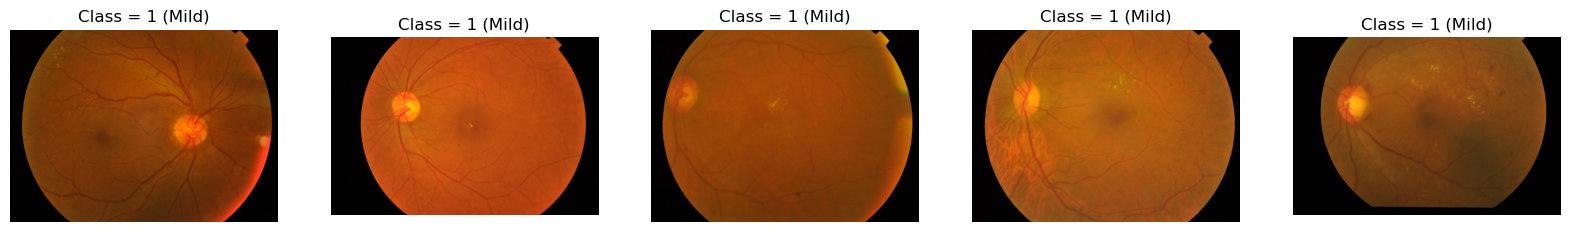

In [23]:
images_per_class(train_labels,5,train_x,False)  #printing 5 random images per each class.

In [39]:
def plotting(img, title,i):
    """
    This function is used for subplots
    Args: img (numpy.ndarray) - image we need to plot
          title(string) - title of the plot
          i (integer) -  column number
    output: None - this function doesn't return anything.
    """
    plt.subplot(1,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

In [25]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
img = 'train_images/201f882365d3.png'  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,5))
plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Step-3: (Drawing circle)',4)
img = obj1.image_preprocessing(img,'True')
plotting(img,'Step-4: (Adding gaussian blur)',5)

In [41]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
img = "train_images/00cb6555d108.png"  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,5))
plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Step-3: (Drawing circle)',4)

print(img1.shape)

(224, 224, 3)


# TESIS ALAND

In [42]:
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the GRAY images'''

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the RGB images'''

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)         
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):

        '''This function is used for adding Gaussian blur (image smoothing technique) which helps in reducing noise in the image.'''

        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        '''This function is used for drawing a circle from the center of the image.'''

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((img_height, img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img
    
    def process1(self,img, is_proces1 = False):
        
        '''This function is used for CLAHE of the image.'''
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r,g,b = cv2.split(img)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        img = clahe.apply(g) #channel green
        img = cv2.merge((r,img,b))
        return img

    def image_preprocessing(self, img, is_cropping = True):

        """
        This function takes an image -> crops the extra dark part, resizes, draw a circle on it, and finally adds a gaussian blur to the images
        Args : image - (numpy.ndarray) an image which we need to process
           cropping - (boolean) whether to perform cropping of extra part(True by Default) or not(False)
           gaussian_blur - (boolean) whether to apply gaussian blur to an image(True by Default) or not(False)
        Output : (numpy.ndarray) preprocessed image
        """

        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        img = self.draw_circle(img)  #calling draw_circle
#         img = self.process1(img, is_proces1) #calling process1
        return img

In [80]:
def images_per_class(class_labels,num, data_x , is_preprocess = False):

    """ 
    This function plots "num" number of images per each class
    Args : class_labels - (Series Object) which contains the class_labels of train or validation sets.
           num - (Integer) sample number of images to be plot per each class
           data_x - (Series Object) which contains the id_code of each point in train or validation sets.
           is_preprocess - (boolean) whether to perform image processing(True) on image or not(False by Default) 
    Output : None - this function doesn't return anything.
    """

    # class_labels num data_x data_y
    labels = list(set(class_labels))
    classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']
    iter=0
    for i in labels:
        j=1
        plt.figure(figsize=(20,4))
        for row in range(len(data_x)):
            if class_labels.iloc[row] == i:
                if is_preprocess == False:plt.subplot(1,num,j)
                else: plt.subplot(1,num*2,j)
                img = cv2.imread('train_images/'+data_x.iloc[row]+'.png')
                img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                plt.imshow(img1)
                plt.axis('off')
                plt.title("Class = {} ({})".format(class_labels.iloc[row],classes[iter]))
                j+=1
                if is_preprocess == True:
                    obj = ImageProcessing(img_width,img_height,no_channels,sigmaX=14)
                    image = obj.image_preprocessing(img)
                    plt.subplot(1,num*2,j)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title('==> After Image Processing')
                    j+=1
            if is_preprocess == False and j>num: break
            elif is_preprocess == True and j>num*2: break
        iter+=1
        plt.show()

In [81]:
def plotting(img, title,i):
    """
    This function is used for subplots
    Args: img (numpy.ndarray) - image we need to plot
          title(string) - title of the plot
          i (integer) -  column number
    output: None - this function doesn't return anything.
    """
    plt.subplot(1,4,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)

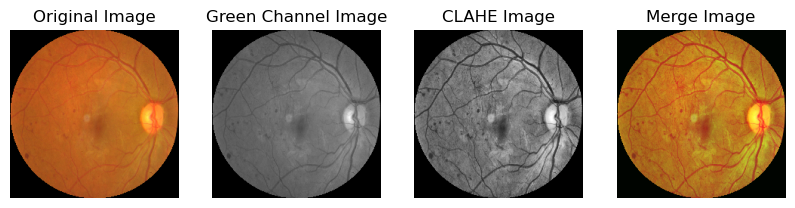

In [78]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 10)
img = "train_images/0af296d2f04a.png"  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,4))
# plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
# plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
# plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Original Image',1)
r,g,b = cv2.split(img1)
img1 = g
plotting(img1, 'Green Channel Image',2)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)) #CLAHE
img1 = clahe.apply(g) #channel green
plotting(img1, 'CLAHE Image',3)
img1 = cv2.merge((r,img1,b)) #gabung
plotting(img1, 'Merge Image',4)
# img1 = cv2.resize(img1, (img_height,img_width))

In [70]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 10)
img = "train_images/0af296d2f04a.png"  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,3))
# plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
# plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
# plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Original Image',1)
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB) #convert LAB
plotting(img1, 'L*a*b* Image',2)
img1 = cv2.addWeighted ( img1,4, cv2.GaussianBlur( img1 , (0,0) , 10) ,-4 ,128) #Gaussian Blur
plotting(img1, 'Gaussian Blur Image',3)

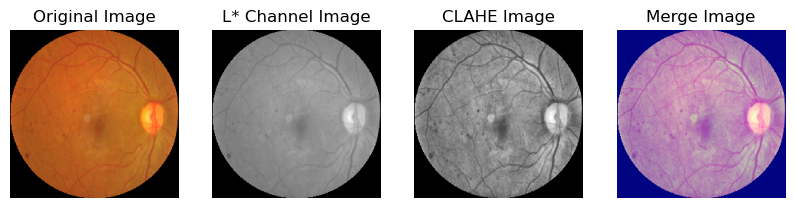

In [82]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 10)
img = "train_images/0af296d2f04a.png"  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,4))
# plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
# plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
# plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Original Image',1)
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB) #convert LAB
# plotting(img1, 'L*a*b* Image',2)
L,a,b = cv2.split(img1)
img1 = L
plotting(img1, 'L* Channel Image',2)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)) #CLAHE
img1 = clahe.apply(img1) #channel green
plotting(img1, 'CLAHE Image',3)
img1 = cv2.merge((r,img1,b)) #gabung
plotting(img1, 'Merge Image',4)
# img1 = cv2.resize(img1, (img_height,img_width))

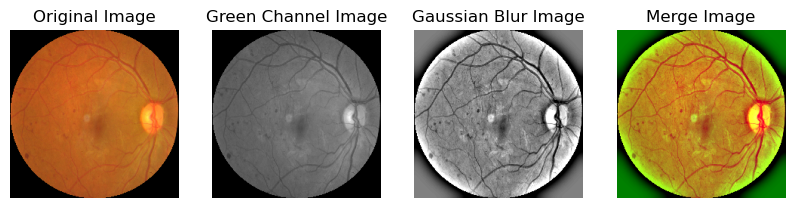

In [85]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 10)
img = "train_images/0af296d2f04a.png"  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,4))
# plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
# plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
# plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Original Image',1)
r,g,b = cv2.split(img1)
img1 = g
plotting(img1, 'Green Channel Image',2)
img1 = cv2.addWeighted ( g,4, cv2.GaussianBlur( g , (0,0) , 10) ,-4 ,128) #Gaussian Blur
plotting(img1, 'Gaussian Blur Image',3)
img1 = cv2.merge((r,img1,b)) #gabung
plotting(img1, 'Merge Image',4)
# img1 = cv2.resize(img1, (img_height,img_width))

**Steps of Image Preprocessing:**

Above preprocessing of images is done in four steps.

*    **Step-1**: All the images contains black background. And we can observe some of the images have extra dark pixels at the sides of the images. So in step-1 involves cropping of those extra dark pixels.
*    **Step-2**: We can see that their is no fixed size for image width and image height. Hence we do resizing of an image in step-2.
*    **Step-3**: Lot of images are shrinked and some images have circular shape and some are cropped at edges. Hence in step-3 we are drawing a circle from the center to give a similar shape to all the images.
*    **Step-4**: As we can observe most of the images are taken in different resolutions. Where some are taken in lighting conditions and some in dark. we are adding a smoothing technique in order to remove the noise in images by using gaussian blur to the images. This gives our final preprocessed image.

**Plotting sample images of each class before and after Image Preprocessing:**

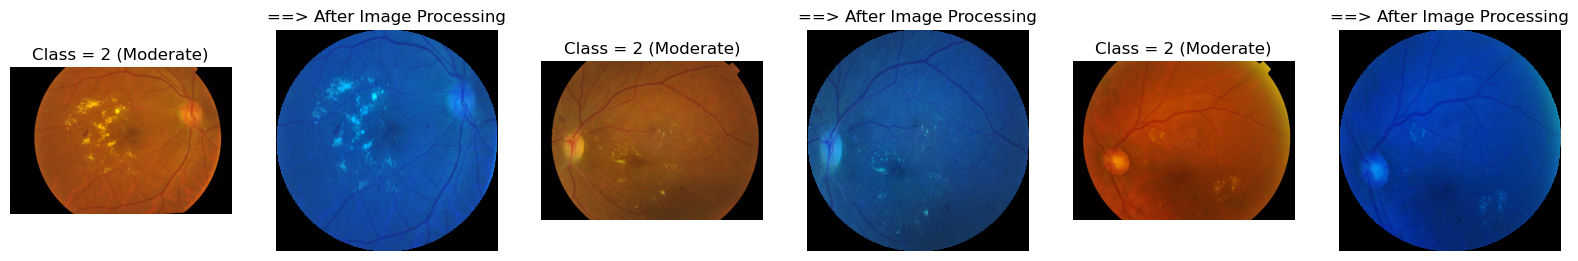

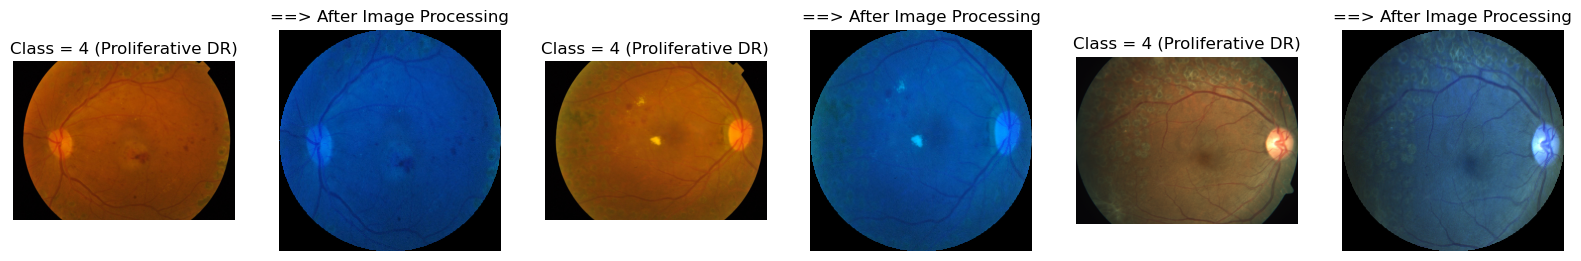

In [83]:
images_per_class(train_labels,3,train_x,True)

I tried using multiple values of sigmaX and the value = 14 works best for this case.

**Converting Images to Vectors and storing it into files:**

*    Image preprocessing is a time taking process. Hence I am storing preprocessed images into a vector to save time on preprocessing images, every time running the program.

### **Image Convertion:**

In [17]:
def image_2_vector(data, sep):
    """
    This function is used for Converting an images into a vector and storing it in a file (.npy) format.
    Input: data (Series Object) - which contains the path of the images
           sep (String)   - used in file creation
    Output: None - This function doesn't return anything.
    """
    start_time = time.time()  # storing timestamp 
    image_vector = np.empty((len(data),img_width, img_height, no_channels), dtype = np.uint8)
    image_processing = ImageProcessing(img_width, img_height, no_channels, sigmaX)  # Object creation
    if sep !='test':
        c = '/content/train_images/'
    else:
        c = '/content/test_images/'
    for iter,row in enumerate(tqdm(data)): 
        img_path = c+data.iloc[iter]+'.png'
        img = cv2.imread(img_path)
        img = image_processing.image_preprocessing(img)    #calling image_preprocessing
        image_vector[iter,:,:,:] = img

    if sep == 'training': print("\nShape of the vector:",image_vector.shape)
    else: print("\n\nShape of the vector:",image_vector.shape)
    print("Time taken to process the {} images: {} seconds".format(sep,np.round(time.time()-start_time,5)))
    path = '/content/drive/My Drive/processed_images'
    print("... Saving image_vector to {}".format(path+'/'+sep))
    
    if sep == 'training': 
        print("\n","-"*100,"\n")
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path+'/'+sep+'.npy', image_vector)  #saving file

In [18]:
sigmaX = 14 
image_2_vector(train_x, "training") # function calling 
image_2_vector(validation_x,"validation")  #function calling 

100%|██████████| 3112/3112 [09:43<00:00,  5.33it/s]



Shape of the vector: (3112, 512, 512, 3)
Time taken to process the training images: 583.81414 seconds
... Saving image_vector to /content/drive/My Drive/processed_images/training

 ---------------------------------------------------------------------------------------------------- 



100%|██████████| 550/550 [01:55<00:00,  4.75it/s]




Shape of the vector: (550, 512, 512, 3)
Time taken to process the validation images: 115.90104 seconds
... Saving image_vector to /content/drive/My Drive/processed_images/validation


In [ ]:
test = pd.read_csv("/content/test.csv") 
image_2_vector(test['id_code'], 'test')   #function calling 

100%|██████████| 1928/1928 [02:39<00:00, 12.07it/s]




Shape of the vector: (1928, 512, 512, 3)
Time taken to process the test images: 159.69072 seconds
... Saving image_vector to /content/drive/My Drive/processed_images/test


In [ ]:
train_x = np.load('/content/drive/My Drive/processed_images/training.npy')  #training set
validation_x = np.load('/content/drive/My Drive/processed_images/validation.npy')  #validation set
test_x = np.load('/content/drive/My Drive/processed_images/test.npy')    #test set

**Testing:**

In [ ]:
plt.figure(figsize=(15,5)) 
plt.subplot(131)
plt.imshow(train_x[8])   #random training example
plt.axis('off') 
plt.title("Training sample image")
plt.subplot(132)
plt.imshow(validation_x[120])    #random validation example
plt.title("Validation sample image")
plt.axis('off')
plt.subplot(133)
plt.imshow(test_x[1200])        #random test example
plt.title("Testing sample image")
plt.axis('off')
plt.show()

**Everything is perfect. Now we are already for model training.**